## 0. Importing libraries

In [1]:
# Importing dependencies
# import the opencv library
import cv2
import mediapipe as mp
import math
import numpy as np

## 1. Defining Video recording function

In [5]:
import cv2

# Function to record simple video of 4 seconds
# Args(camera_index; 1 = PC webcam, 1 = USB cam)
def record_vid(cam_index = 0):
    
    # Set the video capture device (webcam)
    cap = cv2.VideoCapture(cam_index)

    width= int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height= int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Define the codec and create a VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'DIVX')
    # Recording at 25 fps with Camera's original resolution
    out = cv2.VideoWriter('output.mp4',fourcc, 25.0, (width,height))

    # Set the duration of the video capture (in seconds)
    duration = 4

    # Capture frames for the specified duration
    start_time = cv2.getTickCount()
    frame_cnt = 0
    while(int((cv2.getTickCount() - start_time)/cv2.getTickFrequency() * 1000) < duration*1000):
        ret, frame = cap.read()
        
        if ret==True:
            # Show the frame
            cv2.imshow('frame',frame)
            # Write the frame to the output file
            out.write(frame)
            frame_cnt += 1
            # Wait for a key press to exit
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
            
            if frame_cnt == 86:
                break
        else:
            break

    # Release the video capture device and the output file
    cap.release()
    out.release()
    
    # Destroy all the windows
    cv2.destroyAllWindows()

In [6]:
record_vid(cam_index=0)

gg


## 2. Preprocess Video 

In [4]:
# Defining Mediapipe model
mp_holistic = mp.solutions.holistic  # Holistic model
mp_drawing = mp.solutions.drawing_utils  # Drawing utilities

#### - Defining helper functions

In [5]:
#Passing image and model to the function
def mediapipe_detection(image, model):
    # Converting frame from BGR to RGB because model works on RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Color conversion (BGR to RGB)
    
    image.flags.writeable = False # Image not writeable anymore
    
    results = model.process(image)# Making prediction
    
    image.flags.writeable = True # Image is now writeable
    
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # Color conversion (RGB to BGR)
    return image, results

In [6]:
def crop_lips(image, results):
    image_height, image_width, c = image.shape

    #IMPORTANT VARIABLES
    # Defining width and height of resized frame
    width = 100
    height = 50

    # If no lips get detected by mediapipe then exception will be thrown
    try:        
        
        # NORAMALIZING POSITIONS OF LANDMARKS(Two lines below taken from
        x_px1 = min(math.floor(results.face_landmarks.landmark[212].x * image_width), image_width - 1)
        x_px2 = min(math.floor(results.face_landmarks.landmark[432].x * image_width), image_width - 1)
        y_px1 = min(math.floor(results.face_landmarks.landmark[94].y * image_height), image_height - 1)
        y_px2 = min(math.floor(results.face_landmarks.landmark[200].y * image_height), image_height - 1)
        
        # Padding the image
        pad = 0.05
        

        a = math.floor(x_px1 * (1 - pad))
        b = math.floor(x_px2 * (1 + pad))
        c = math.floor(y_px1 * (1 - pad))
        d = math.floor(y_px2 * (1 + pad))
        
        #print("X = ",x_px1," ",x_px2)
        #print("AB= ",a, " ",b)
        #print("Y = ",y_px1," ",y_px2)
        #print("CD= ",c," ",d)
        
        # Cropping an image
        #cropped_image = image[y_px1:y_px2, x_px1:x_px2]
        cropped_image = image[c:d, a:b]

        # Resizing the cropped image to Fixed resolution i.e. 300*150
        dim = (width, height)

        resized = cv2.resize(cropped_image, dim, interpolation=cv2.INTER_AREA)

    except:
        # If no lips detected plain black frame will be returned
        resized = np.zeros((height, width, 3), dtype=np.uint8)


    return resized

In [7]:
def lip_movement_detected(results):
    diff = results.face_landmarks.landmark[14].y - results.face_landmarks.landmark[13].y
    if diff > 0.008:
        return True
    else:
        return False

#### - Defining Preprocessing function

In [8]:
def preprocess_vid(directory):

    # Total frames in model input
    SEQUENCE_LENGTH = 75

    # Declare a queue to store video frames.
    frames_list = []

    # Create a VideoCapture object and read from input file
    cap = cv2.VideoCapture(directory)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Check if camera opened successfully
    if (cap.isOpened()== False):
        print("Error opening video file")

    sil_flag = True

    frame_cnt = 0

    sil_flag_list = []

    with mp_holistic.Holistic(min_detection_confidence=0.1, min_tracking_confidence=0.1) as holistic:    
        # Read until video is completed
        while(cap.isOpened()):

            # Capture frame-by-frame
            ret, frame = cap.read()

            # If frame correctly read only then performing predictions
            if ret == True:
                
                frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
                
                image, results = mediapipe_detection(frame, holistic)

                # Cropping lips
                cropped_image = crop_lips(frame, results)

                # Normalizing the cropped frame
                normalized_frame = cropped_image / 255 

                # Appending lips frame to frames_list
                frames_list.append(normalized_frame)

                # Appending sil flag in list
                sil_flag_list.append(lip_movement_detected(results))

                # Display the frame
                #cv2.imshow('Frame',frame)



            # Press Q on keyboard to exit
            #    if cv2.waitKey(25) & 0xFF == ord('q'):
            #        break

            # Break the loop
            else:
                break


     # When everything done, release the video capture object
    cap.release()

    # Closes all the frames
    cv2.destroyAllWindows()

    # Following code identifies last frame after which speaker is silent
    last_index = len(sil_flag_list)
    for i in range(len(sil_flag_list)-1, len(sil_flag_list)-30, -1):

        if len(set(sil_flag_list[i:])) == 1:
            last_index = i
        else:
            break

    # Following code identifies last frame of sil at start
    start_index = 0
    for i in range(1,30):

        if len(set(sil_flag_list[0:i])) == 1:
            start_index = i
        else:
            break

    # Padding the list if after sil removal it gets has than 75 frames
    if (last_index - start_index) < SEQUENCE_LENGTH:
        # Equal frames from start and end padded if possible
        new_start_index = start_index
        new_last_index = last_index

        while((new_last_index - new_start_index) < SEQUENCE_LENGTH):

            if new_start_index > 0:
                new_start_index -= 1

            if (new_last_index - new_start_index) == SEQUENCE_LENGTH:
                break

            if new_last_index < len(frames_list)-1:
                new_last_index += 1

            if (new_last_index - new_start_index) == SEQUENCE_LENGTH:
                break  

        frames_list = frames_list[new_start_index : new_last_index]

    else:
        # if frames are more than 75 last extra frames discarded

        num_extra_frames = abs(SEQUENCE_LENGTH - (last_index-start_index))

        new_last_index = last_index - num_extra_frames

        frames_list = frames_list[start_index : new_last_index]
    
    return np.array(frames_list)

In [9]:
frames_list = preprocess_vid("_video.avi")

In [86]:
len(frames_list)

75

In [87]:
frames_list.shape

(75, 50, 100, 3)

In [100]:
cv2.imshow("win",frames_list[0])
cv2.waitKey(0)

-1

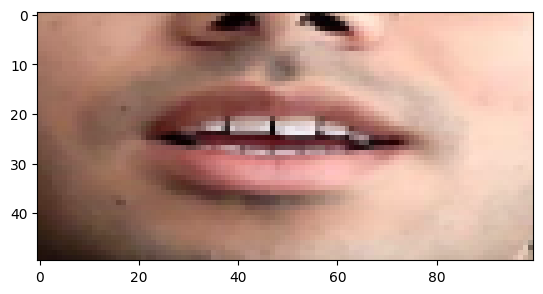

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

imgplot = plt.imshow(frames_list[0])
plt.show()

In [11]:
for i in frames_list:
    cv2.imshow('Input', i)


    i=i+1
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break